In [1]:
%load_ext autoreload
%autoreload 2
from functions import *
%matplotlib widget

In [ ]:
SurfaceSourceFile = kds.SurfaceSourceFile("surface_source.mcpl", domain={"w": [0, 1]})
df = SurfaceSourceFile.get_pandas_dataframe()
del SurfaceSourceFile

In [3]:
# columns_order = ["x", "y", "ln(E0/E)", "mu", "phi", "wgt"]
columns_order = ["x", "y", "ln(E0/E)", "mu"]
# columns_order = ["x","y","ln(E0/E)"]
df = df[columns_order]

In [5]:
micro_bins = [150] * len(columns_order)
# macro_bins = [25] * len(columns_order)
# macro_bins = [15,10,8,6,5,5]
macro_bins = [20,20,15,15]
# macro_bins = [12,12,8,8,5,5]
# macro_bins = [100,100,100]

In [6]:
cumul, micro, macro = calculate_cumulative_histograms(df, columns_order, micro_bins, macro_bins, type="equal_area")

In [19]:
sampled_df = sample_nd(cumul,micro, macro, columns_order,4_000_000)

In [ ]:
plot_correlated_variables(sampled_df, columns_order)

In [ ]:
from scipy.stats import entropy
import numpy as np

kl_divergence = entropy(np.histogram(df["x"])[0], np.histogram(sampled_df["x"])[0])
print(kl_divergence)


In [ ]:
from scipy.stats import wasserstein_distance

distance = wasserstein_distance(df["x"], sampled_df["x"])
print(distance)


In [ ]:
corr_original = df.corr(method='pearson')
corr_synthetic = sampled_df.corr(method='pearson')

print(corr_original)
print(corr_synthetic)

# Barrido

Voy a probar barrer diferentes configuraciones y analizar como varian los tiempos y las distancias

In [ ]:
# Datos
columns_order = ["x", "y", "ln(E0/E)", "mu", "phi", "wgt"]
micro_bins = [150] * len(columns_order)
macro_bins = [15, 10, 8, 6, 5, 5]
N = np.logspace(1, 5, 10, base=10, dtype=int)
type = "equal_area"

time_histo =[]
time_sample = []

kl_divergence = []
distance = []

for i in range(len(columns_order)):
    kl_divergence.append([columns_order[i]])
    distance.append([columns_order[i]])

for n in N:
    time_histo_batch, time_sample_batch, kl_diverg_aux, distance_aux = testeo("surface_source.mcpl", columns_order, micro_bins, macro_bins, n, type)
    time_histo.append(time_histo_batch)
    time_sample.append(time_sample_batch)

    for i in range(len(columns_order)):
        kl_divergence[i].append(kl_diverg_aux[i])
        distance[i].append(distance_aux[i])


In [ ]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1: Time for histograms
axes[0, 0].loglog(N, time_histo, label="time_histograms")
axes[0, 0].set_xlabel("Number of samples")
axes[0, 0].set_ylabel("Time [s]")
axes[0, 0].legend()
axes[0, 0].grid()

# Plot 2: Time for sampling
axes[0, 1].loglog(N, time_sample, label="time_sampling")
axes[0, 1].set_xlabel("Number of samples")
axes[0, 1].set_ylabel("Time [s]")
axes[0, 1].legend()
axes[0, 1].grid()

# Plot 3: KL divergence
for kl in kl_divergence:
    axes[1, 0].loglog(N, kl[1:], label="kl_divergence " + kl[0])
axes[1, 0].set_xlabel("Number of samples")
axes[1, 0].set_ylabel("KL divergence")
axes[1, 0].legend()
axes[1, 0].grid()

# Plot 4: Wasserstein distance
for dist in distance:
    axes[1, 1].loglog(N, dist[1:], label="wasserstein_distance " + dist[0])
axes[1, 1].set_xlabel("Number of samples")
axes[1, 1].set_ylabel("Wasserstein distance")
axes[1, 1].legend()
axes[1, 1].grid()

# Add title with information of the run
fig.suptitle("Columns order: " + str(columns_order) + "\n" + "Micro bins: " + str(micro_bins) + "\n" + "Macro bins: " + str(macro_bins) + "\n" + "Type: " + type)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
c = [1,2,3,4]
d = c
d.append(5)

print(c + [7])
print(d)

# Prueba con batches

In [2]:
# Data to test
columns_order = ["x", "y", "ln(E0/E)", "mu", "phi"]
micro_bins = [150] * len(columns_order)
macro_bins = [15, 10, 8, 6, 5]
N = np.logspace(3, 6, 4, base=10, dtype=int)
batches = 4
type = "equal_bins"

test = []

# Read the surface source file
SurfaceSourceFile = kds.SurfaceSourceFile("surface_source.mcpl", domain={"w": [0, 1]})
df = SurfaceSourceFile.get_pandas_dataframe()
del SurfaceSourceFile
df = df[columns_order + ["wgt"]]

# Calculate the original histogram
counts_original, edges = [], []

for column in columns_order:
    counts_aux, edges_aux = np.histogram(df[column], bins=100, weights=df["wgt"])
    counts_aux = counts_aux / sum(counts_aux)
    change_zeros(counts_aux)
    counts_original.append(counts_aux)
    edges.append(edges_aux)
    del counts_aux, edges_aux

counts_2d_original, edges_2d_1, edges_2d_2 = [], [], []

for i in range(len(columns_order) - 1):
    for j in range(i + 1, len(columns_order)):
        counts_2d_original_aux, edges_2d_1_aux, edges_2d_2_aux = np.histogram2d(
            df[columns_order[i]], df[columns_order[j]], bins=100, weights=df["wgt"]
        )
        counts_2d_original.append(counts_2d_original_aux)
        edges_2d_1.append(edges_2d_1_aux)
        edges_2d_2.append(edges_2d_2_aux)

time_histo = []
time_histo.append("Tiempo de calculo de los histogramas")
time_sample = []
time_sample.append("Tiempo de muestreo")
kl_divergence = []

# Initialize kl_divergence with the name of the columns to later use in the plots
for i in range(len(columns_order)):
    kl_divergence.append([columns_order[i]])

for n in N:
    print("Number of samples: ", n)

    # Initialize variables to store the results of the batches
    time_histo_container, time_sample_container, counts_container = 0, 0, []

    for i in range(len(columns_order)):
        counts_container.append([])
        for _ in range(len(counts_original[i])):
            counts_container[i].append(0)

    # Run the batches
    for batch in range(batches):
        print("Batch: ", batch + 1)

        time_histo_batch, time_sample_batch, counts_batch, counts_2d_batch = (
            get_time_and_counts(
                df,
                columns_order,
                micro_bins,
                macro_bins,
                n,
                edges,
                edges_2d_1,
                edges_2d_2,
                type,
            )
        )
        time_histo_container += time_histo_batch
        time_sample_container += time_sample_batch
        for i in range(len(counts_original)):
            # counts_container[i] += counts_batch[i]
            for j in range(len(counts_original[i])):
                counts_container[i][j] += counts_batch[i][j]

    # normalize counts_container and take aways the zeros
    for i in range(len(counts_container)):
        total = sum(counts_container[i])
        counts_container[i] = [x / total for x in counts_container[i]]
        change_zeros(counts_container[i])

    # plt.figure()
    # plt.stairs(
    #     counts_original[2], edges[2], label="original" + str(sum(counts_original[2]))
    # )
    # plt.stairs(
    #     counts_container[2], edges[2], label="synthetic" + str(sum(counts_container[2]))
    # )
    # plt.legend()
    # plt.show()

    # Calculate the kl divergence
    for i in range(len(counts_original)):
        # if i == 2:
        #     test.append(counts_container[i])
        kl_divergence[i].append(sum(rel_entr(counts_original[i], counts_container[i])))

    # Append the time results
    time_histo.append(time_histo_batch)
    time_sample.append(time_sample_batch)

Number of particles in file surface_source.mcpl: 3514158
100% n, 0% g, 0% e-, 0% e+, 0% p, 
Number of samples:  512
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Number of samples:  4096
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Number of samples:  32768
Batch:  0
Batch:  1
Batch:  2
Batch:  3
Number of samples:  262144
Batch:  0
Batch:  1
Batch:  2
Batch:  3


Number of samples:  2048
Number of samples:  16384
Number of samples:  131072
Number of samples:  1048576


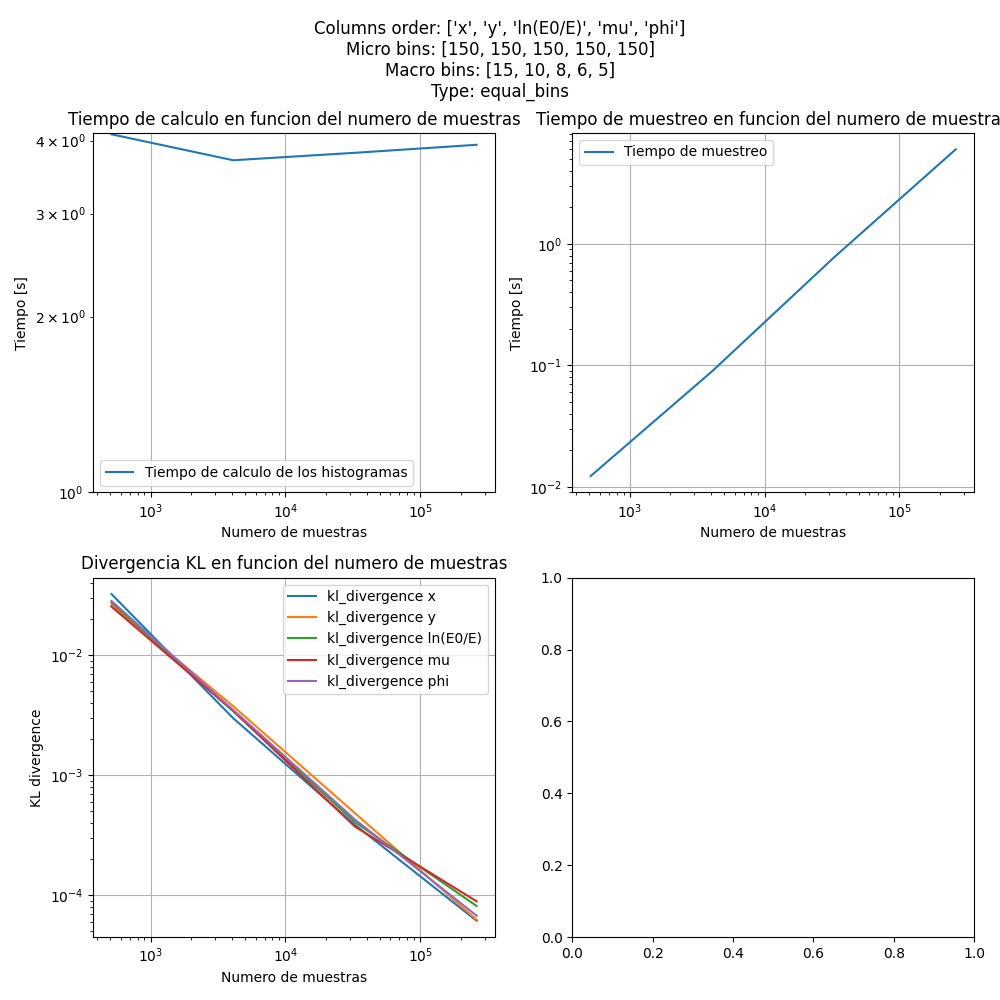

In [3]:
for n in N:
    n = n * batches
    print("Number of samples: ", n)

# for kl in kl_divergence:
#     for i in range(0, len(kl)-1):
#         kl[i+1] = -kl[i+1]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1: Time for histograms
axes[0, 0].loglog(N, time_histo[1:], label=time_histo[0])
axes[0, 0].set_xlabel("Numero de muestras")
axes[0, 0].set_ylabel("Tiempo [s]")
axes[0, 0].legend()
axes[0, 0].grid()
axes[0, 0].set_ylim(bottom=1) 
axes[0, 0].set_title("Tiempo de calculo en funcion del numero de muestras")

# Plot 2: Time for sampling
axes[0, 1].loglog(N, time_sample[1:], label=time_sample[0])
axes[0, 1].set_xlabel("Numero de muestras")
axes[0, 1].set_ylabel("Tiempo [s]")
axes[0, 1].legend()
axes[0, 1].grid()
axes[0, 0].set_ylim(bottom=1) 
axes[0, 1].set_title("Tiempo de muestreo en funcion del numero de muestras")

# Plot 3: KL divergence
for kl in kl_divergence:
    axes[1, 0].loglog(N, kl[1:], label="kl_divergence " + kl[0])
axes[1, 0].set_xlabel("Numero de muestras")
axes[1, 0].set_ylabel("KL divergence")
axes[1, 0].legend()
axes[1, 0].grid()
axes[1, 0].set_title("Divergencia KL en funcion del numero de muestras")

# # Plot 4: Wasserstein distance
# for dist in distance:
#     axes[1, 1].loglog(N, dist[1:], label="wasserstein_distance " + dist[0])
# axes[1, 1].set_xlabel("Number of samples")
# axes[1, 1].set_ylabel("Wasserstein distance")
# axes[1, 1].legend()
# axes[1, 1].grid()

# Add title with information of the run
fig.suptitle("Columns order: " + str(columns_order) + "\n" + "Micro bins: " + str(micro_bins) + "\n" + "Macro bins: " + str(macro_bins) + "\n" + "Type: " + type)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [17]:
a = ["a", "b", "c", "d"]

for i in range(len(a)-1):
    for j in range(i+1, len(a)):
        print(i,j)
        





[0.08526377836227758, 0.010308143074786188, 0.0020236811394399685, 0.0004585372309504244, 0.00014355734621460602]


In [16]:
print(test[4])
print(counts_original[2])

[0.11796188354492188, 0.036838531494140625, 0.027708053588867188, 0.020122528076171875, 0.015346527099609375, 0.014287948608398438, 0.011280059814453125, 0.008069992065429688, 0.0077419281005859375, 0.00653839111328125, 0.0055446624755859375, 0.0048999786376953125, 0.004192352294921875, 0.0040283203125, 0.00344085693359375, 0.003276824951171875, 0.003101348876953125, 0.00272369384765625, 0.002643585205078125, 0.002620697021484375, 0.0025615692138671875, 0.0025005340576171875, 0.002445220947265625, 0.0023593902587890625, 0.00218963623046875, 0.002239227294921875, 0.002170562744140625, 0.0022945404052734375, 0.002315521240234375, 0.0022754669189453125, 0.0024929046630859375, 0.002227783203125, 0.002170562744140625, 0.002262115478515625, 0.002197265625, 0.0022220611572265625, 0.0022182464599609375, 0.0022487640380859375, 0.00223541259765625, 0.0023136138916015625, 0.002193450927734375, 0.0020580291748046875, 0.0022830963134765625, 0.0022907257080078125, 0.002086639404296875, 0.00222206115